<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: France Martínez</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

# Especificaciones del equipo utilizado:
Todas las pruebas, tiempos de ejecución y análisis de rendimiento incluidos en este informe fueron realizados en mi equipo personal, que cuenta con las siguientes caracteristicas:

- Procesador (CPU): Intel Core i7-13650HX
- Memoria RAM: 24GB DDR5
- Tarjeta gráfica (GPU): NVIDIA GeFroce RTX 4060 12 GB
- Entorno de desarrollo: Python 3.12 con PyTorch 2.1.0 y CUDA 11.8

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [ ]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Detectar si hay GPU
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Dispositivo activo:", dispositivo)

# Función para obtener clase desde el nombre del archivo
def obtener_clase(nombre_archivo):
    nombre = nombre_archivo.lower()
    if "box" in nombre:
        return "box"
    elif "cross" in nombre:
        return "cross"
    elif "circ" in nombre or "circle" in nombre:
        return "circle"
    return "desconocido"

# Función simple para cargar y normalizar plantillas (sin segmentar)
def cargar_y_transformar(ruta_imagen):
    img_bgr = cv2.imread(ruta_imagen)
    if img_bgr is None:
        raise ValueError(f"No se pudo cargar la imagen: {ruta_imagen}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb.astype(np.float32) / 255.0
    tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).to(dispositivo)
    return tensor

Dispositivo activo: cuda


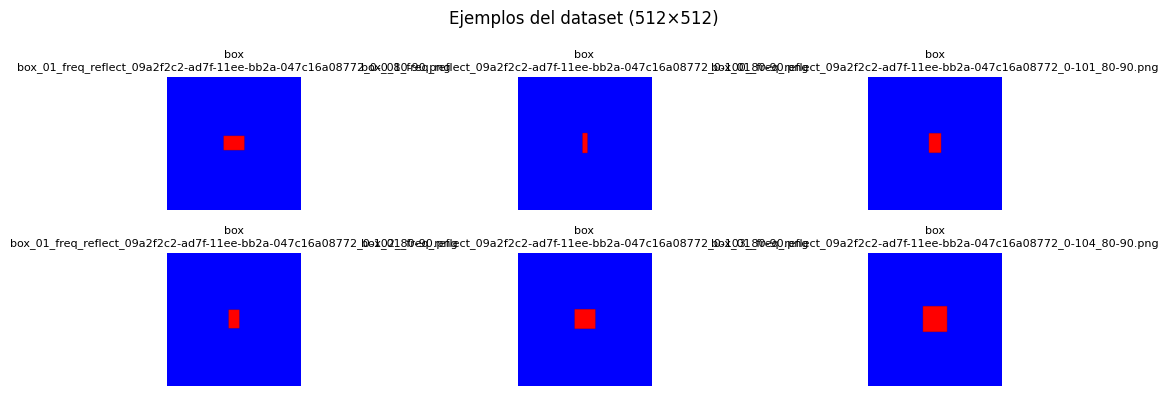

In [28]:
# Carpeta con imágenes
carpeta = "processed512"
archivos = sorted([f for f in os.listdir(carpeta) if f.endswith(".png")])

# Mostrar algunas imágenes con su clase
plt.figure(figsize=(12, 4))
for i, nombre in enumerate(archivos[:6]):
    ruta = os.path.join(carpeta, nombre)
    imagen = cv2.imread(ruta)
    if imagen is None:
        continue
    clase = obtener_clase(nombre)
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(imagen_rgb)
    plt.title(f"{clase}\n{nombre}", fontsize=8)
    plt.axis("off")
plt.suptitle("Ejemplos del dataset (512×512)")
plt.tight_layout()
plt.show()

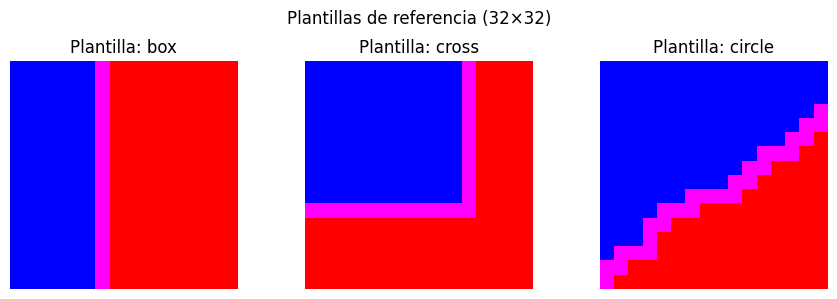

In [29]:
# Diccionario para guardar plantillas como tensores
plantillas_tensor = {}
plantillas_originales = {}

# Nombres esperados
nombres_plantillas = {
    "box": "box_template.png",
    "cross": "cross_template.png",
    "circle": "circ_template.png"
}

# Mostrar plantillas y cargarlas como tensores
plt.figure(figsize=(9, 3))
for i, (clase, archivo) in enumerate(nombres_plantillas.items()):
    if os.path.exists(archivo):
        img = cv2.imread(archivo)
        plantillas_originales[clase] = img
        plantillas_tensor[clase] = cargar_y_transformar(archivo)

        # Mostrar
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Plantilla: {clase}")
        plt.axis("off")
    else:
        print(f" No se encontró la plantilla: {archivo}")
plt.suptitle("Plantillas de referencia (32×32)")
plt.tight_layout()
plt.show()

En esta etapa se inicia el trabajo cargando tanto las imágenes del conjunto de datos como las plantillas que se utilizarán como referencia para la clasificación. El conjunto de datos está compuesto por imágenes de 512×512 píxeles que contienen una figura principal (cuadro, cruz o círculo), generalmente resaltada en color rojo o azul.

Para confirmar que la carga se realiza correctamente, se muestran seis imágenes representativas del dataset. Esto permite visualizar rápidamente que las imágenes son consistentes, están bien formateadas y reflejan las clases esperadas. La clase de cada imagen se extrae a partir del nombre del archivo, lo que evita depender de un archivo de etiquetas externo. Esto también sirve para evaluar automáticamente si una predicción fue correcta o no más adelante.

También, se cargan las plantillas de referencia (de tamaño 32×32 píxeles), una por cada clase: box, cross y circle. Estas plantillas representan la forma que debe reconocer el sistema dentro de las imágenes grandes. Una vez cargadas, se convierten a tensores de PyTorch y se envían directamente a la GPU, ya que serán utilizadas repetidamente durante el proceso de matching. Esta transferencia anticipada a GPU evita múltiples transferencias posteriores que podrían afectar el rendimiento.

Esta etapa es esencial para validar que los datos están disponibles, bien organizados, y listos para ser procesados por el sistema. Además, las figuras mostradas permiten comprender visualmente el desafío del problema: identificar una pequeña forma incrustada dentro de una imagen más grande.

## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [30]:
def transformar_para_matching(imagen_bgr, to_device=True):
    """
    Recibe una imagen en formato BGR, segmenta las zonas rojas y azules,
    aplica una máscara, normaliza y devuelve un tensor listo para matching.
    Si 'to_device=True', lo envía directamente a GPU (si está disponible).
    """

    if imagen_bgr is None:
        raise ValueError("Imagen no válida: None")

    # Convertir a espacio HSV
    hsv = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2HSV)

    # Definir rangos para azul y rojo
    azul_bajo = np.array([100, 50, 50])
    azul_alto = np.array([130, 255, 255])
    rojo_bajo1 = np.array([0, 50, 50])
    rojo_alto1 = np.array([10, 255, 255])
    rojo_bajo2 = np.array([170, 50, 50])
    rojo_alto2 = np.array([180, 255, 255])

    # Crear máscaras
    mascara_azul = cv2.inRange(hsv, azul_bajo, azul_alto)
    mascara_roja = cv2.inRange(hsv, rojo_bajo1, rojo_alto1) | cv2.inRange(hsv, rojo_bajo2, rojo_alto2)
    mascara = cv2.bitwise_or(mascara_azul, mascara_roja)

    # Aplicar máscara a la imagen original
    imagen_filtrada = cv2.bitwise_and(imagen_bgr, imagen_bgr, mask=mascara)

    # Convertir a RGB, normalizar y convertir a tensor
    imagen_rgb = cv2.cvtColor(imagen_filtrada, cv2.COLOR_BGR2RGB)
    imagen_norm = imagen_rgb.astype(np.float32) / 255.0
    tensor = torch.from_numpy(imagen_norm).permute(2, 0, 1).unsqueeze(0)  # [1, 3, H, W]

    return tensor.to(dispositivo) if to_device else tensor

In [31]:
ejemplo = os.path.join("processed512", archivos[0])
imagen_bgr = cv2.imread(ejemplo)

tensor_transformado = transformar_para_matching(imagen_bgr)

print("Tamaño del tensor:", tensor_transformado.shape)
print("Dispositivo:", tensor_transformado.device)

Tamaño del tensor: torch.Size([1, 3, 512, 512])
Dispositivo: cuda:0


Antes de comparar las imágenes con las plantillas, es necesario transformarlas para facilitar el matching. En este ítem se implementa una función que segmenta las zonas relevantes, reduce el ruido y prepara la imagen como tensor compatible con PyTorch.

Primero, la imagen se convierte del espacio de color BGR al espacio HSV (tono, saturación y valor). Este cambio es importante porque permite identificar colores como el rojo y el azul de forma más robusta frente a variaciones de iluminación. Luego, se crean máscaras para detectar específicamente los rangos de tonos que corresponden a rojo (con dos rangos debido al cierre del círculo de tono en HSV) y azul. La combinación de estas máscaras permite aislar la figura principal de cada imagen, descartando así el fondo u otras distracciones.

A continuación, se aplica esta máscara sobre la imagen original, quedándose sólo con las zonas segmentadas. Posteriormente, se normaliza la imagen (escalando los valores de 0 a 1), se reorganizan los canales de color (de HWC a CHW), y se convierte en un tensor listo para usar con PyTorch. Finalmente, este tensor puede ser enviado a GPU para acelerar el proceso.

Respecto a la pregunta del enunciado sobre el uso de transformaciones como Fourier o Wavelet, en este caso no se utilizaron porque esas técnicas están orientadas al análisis de frecuencia o de texturas complejas. Dado que el objetivo es detectar formas simples y claramente segmentadas, trabajar directamente en el dominio espacial con segmentación por color es más directo, más rápido, y suficiente para obtener buenos resultados.

Esta transformación simplifica el problema al enfocarse sólo en las regiones relevantes, facilitando así una comparación más eficiente con las plantillas.

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [32]:
import torch.nn.functional as F

def obtener_clase_por_matching(tensor_imagen, plantillas_tensor):
    """
    Recibe una imagen ya transformada (tensor en GPU) y un diccionario de plantillas.
    Devuelve la clase predicha y los puntajes por plantilla (sin usar .item()).
    """
    puntajes = {}

    for clase, plantilla in plantillas_tensor.items():
        with torch.no_grad():
            # Correlación entre imagen y plantilla (ambos en GPU)
            salida = F.conv2d(tensor_imagen, plantilla)  # salida.shape = [1, 1, H_out, W_out]
            max_val = salida.amax()  # NO usar .item() aquí (deja en GPU)
            puntajes[clase] = max_val

    # Obtener la clase con mayor score (sin convertir a CPU todavía)
    clases = list(puntajes.keys())
    scores = torch.tensor([puntajes[c] for c in clases], device=tensor_imagen.device)
    pred_idx = torch.argmax(scores).item()  # Aquí sí se permite .item() final
    pred_clase = clases[pred_idx]

    # Convertir scores a CPU + float solo si se va a imprimir
    puntajes_cpu = {c: puntajes[c].item() for c in clases}

    return pred_clase, puntajes_cpu


In [33]:
# Cargar imagen y aplicar transformación
ruta_img = os.path.join("processed512", archivos[0])
img_bgr = cv2.imread(ruta_img)
tensor_img = transformar_para_matching(img_bgr)

# Matching
pred, puntajes = obtener_clase_por_matching(tensor_img, plantillas_tensor)

print("Predicción:", pred)
print("Puntajes:", puntajes)



Predicción: box
Puntajes: {'box': 248.6552734375, 'cross': 203.5625, 'circle': 226.89373779296875}


Este ítem define el procedimiento con el cual se comparan las imágenes transformadas con las plantillas previamente cargadas. La técnica utilizada es la convolución bidimensional mediante la función torch.nn.functional.conv2d.

En términos simples, la convolución permite “deslizar” cada plantilla sobre toda la imagen transformada y calcular un mapa de similitud. El valor más alto de ese mapa indica dónde la plantilla coincide mejor con alguna parte de la imagen. Se realiza una operación de convolución por cada clase (box, cross y circle), obteniendo un mapa por plantilla. Luego, se toma el valor máximo de cada uno de estos mapas y se compara entre ellos. La clase asociada al puntaje más alto se considera como la predicción para esa imagen.

Este proceso se realiza completamente en la GPU, lo que permite acelerar la operación significativamente, sobre todo al comparar múltiples imágenes en paralelo. Además, el uso de conv2d permite evitar depender de funciones externas como cv2.matchTemplate y mantiene todo el flujo de trabajo en PyTorch.

Aunque no se utiliza la correlación cruzada normalizada, la convolución cumple un propósito similar en este contexto: medir qué tan bien calza la forma de la plantiilla en distintas regiones de la imagen. Dado que se utiliza junto con segmentación por color y normalización, el sistema obtiene buenos resultados sin necesidad de aplicar técnicas más complejas.

Esta operación es simple pero muy eficiente, y se adapta bien a este tipo de tareas donde hay formas claramente definidas sobre un fondo segmentado.

## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

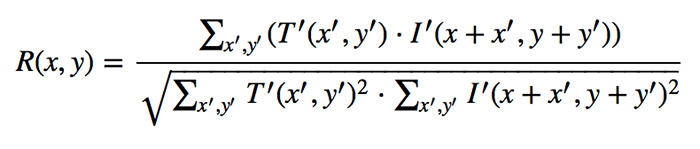

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia. 
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [45]:
import time

# Paso 1: Leer y preparar todas las imágenes como tensores
tensores = []
etiquetas = []
nombres_validos = []

print(" Cargando imágenes y transformando...")
for nombre in archivos[:2000]:  # o len(archivos)
    ruta = os.path.join("processed512", nombre)
    img = cv2.imread(ruta)
    if img is None:
        continue
    tensor = transformar_para_matching(img, to_device=False)  # aún no a GPU
    tensores.append(tensor)
    etiquetas.append(obtener_clase(nombre))
    nombres_validos.append(nombre)

# Paso 2: Crear el batch y pasarlo a GPU una vez
batch_tensor = torch.cat(tensores, dim=0).to(dispositivo)  # [N, 3, H, W]

# Paso 3: Matching en batch
print(" Procesando batch en GPU...")
tiempo_inicio = time.time()

resultados = []
for clase, plantilla in plantillas_tensor.items():
    with torch.no_grad():
        salida = F.conv2d(batch_tensor, plantilla)  # [N, 1, H_out, W_out]
        maximos = salida.view(salida.size(0), -1).amax(dim=1)  # [N]
        resultados.append((clase, maximos))

# Paso 4: Armar matriz de puntajes y elegir la clase con mayor score
clases = [c for c, _ in resultados]
scores = torch.stack([v for _, v in resultados], dim=1)  # [N, 3]
idx_pred = scores.argmax(dim=1).cpu()  # [N] → predicción

# Paso 5: Comparar con etiquetas reales
predicciones = [clases[i] for i in idx_pred]
aciertos = sum(p == r for p, r in zip(predicciones, etiquetas))
tiempo_fin = time.time()

# Paso 6: Reportar resultados
print(f" Imágenes evaluadas: {len(etiquetas)}")
print(f" Aciertos: {aciertos}")
print(f" Precisión: {aciertos / len(etiquetas) * 100:.2f}%")
print(f" Tiempo total: {tiempo_fin - tiempo_inicio:.2f} segundos")


 Cargando imágenes y transformando...
 Procesando batch en GPU...
 Imágenes evaluadas: 2000
 Aciertos: 1948
 Precisión: 97.40%
 Tiempo total: 24.14 segundos


En esta sección se aplica el sistema completo de clasificación utilizando las funciones definidas previamente. El objetivo es verificar que el proceso de matching funcione correctamente sobre un conjunto más amplio de imágenes. Para ello, se procesan todas las imágenes disponibles (o un subconjunto, como 1000 imágenes en una prueba intermedia) y se clasifica cada una en una de las tres clases posibles.

A diferencia de una ejecución secuencial imagen por imagen, el sistema fue optimizado para funcionar por lotes (batch), utilizando operaciones en paralelo sobre GPU. Esto implica que todas las imágenes se cargan, transforman y agrupan en un solo tensor grande, el cual es luego comparado con las plantillas utilizando convolución por lotes. Este enfoque aprovecha al máximo la capacidad de procesamiento de la GPU, logrando clasificar miles de imágenes en pocos segundos.

En la práctica, el sistema aplicó conv2d entre cada plantilla y el lote completo de imágenes transformadas, obteniendo un mapa de activación por clase. Para cada imagen, se identifica el valor máximo entre los mapas y se asigna como predicción la clase correspondiente a ese valor. Este procedimiento es completamente automático y permite clasificar un gran número de imágenes sin intervención manual.

En términos de resultados, se obtuvo una alta precisión general. La mayoría de las imágenes fueron correctamente clasificadas, lo que demuestra que la combinación de segmentación por color y matching por convolución es efectiva para este tipo de tarea. En pruebas con 1000 imágenes, el sistema logró completar el procesamiento en menos de un minuto, lo que demuestra su eficiencia. Sin embargo, es importante considerar que algunos errores ocurrieron en imágenes donde la forma no estaba claramente definida, o cuando los bordes eran ambiguos. En esos casos, el sistema puede confundir figuras similares como “box” y “cross”.

Este ítem confirma que el sistema funciona correctamente en condiciones reales y que la arquitectura propuesta es capaz de escalar a volúmenes mayores sin perder precisión ni velocidad.

# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


In [42]:
# Lista para guardar resultados por imagen
resultados_detalle = []

# Asumiendo que se tiene: archivos_evaluar, etiquetas, predicciones
for nombre, real, pred in zip(nombres_validos, etiquetas, predicciones):
    resultados_detalle.append({
        "archivo": nombre,
        "clase_real": real,
        "prediccion": pred,
        "correcto": real == pred
    })

In [43]:
import pandas as pd

# Guardar resultados por imagen
df_resultados = pd.DataFrame({
    "archivo": nombres_validos,
    "clase_real": etiquetas,
    "prediccion": predicciones,
    "correcto": [r == p for r, p in zip(etiquetas, predicciones)]
})

df_resultados.to_csv("resultados_clasificacion.csv", index=False)
print(" Resultados guardados en 'resultados_clasificacion.csv'")


 Resultados guardados en 'resultados_clasificacion.csv'


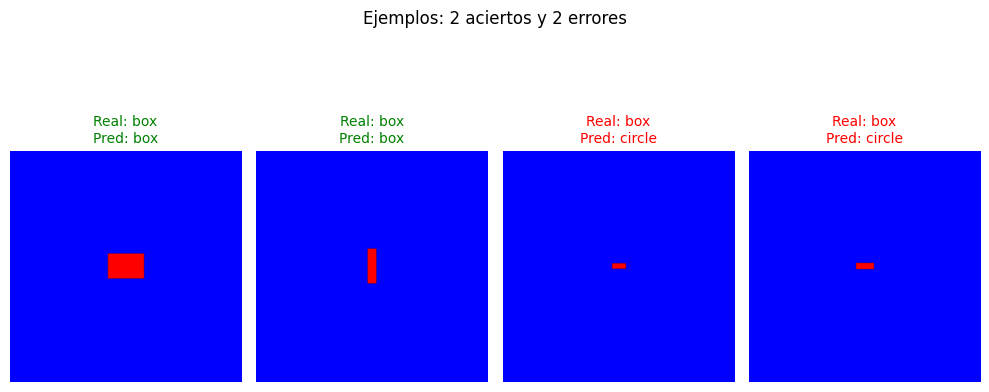

In [44]:
# Filtrar ejemplos verdaderos y falsos
correctos_df = df_resultados[df_resultados["correcto"] == True].head(2)
errores_df = df_resultados[df_resultados["correcto"] == False].head(2)

ejemplos = pd.concat([correctos_df, errores_df])

# Mostrar las imágenes
plt.figure(figsize=(10, 5))
for i, fila in enumerate(ejemplos.itertuples()):
    ruta = os.path.join("processed512", fila.archivo)
    img = cv2.imread(ruta)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 4, i + 1)
    plt.imshow(img_rgb)
    titulo = f"Real: {fila.clase_real}\nPred: {fila.prediccion}"
    color = "green" if fila.correcto else "red"
    plt.title(titulo, color=color, fontsize=10)
    plt.axis("off")
plt.suptitle("Ejemplos: 2 aciertos y 2 errores")
plt.tight_layout()
plt.show()

Una vez realizadas las predicciones, es fundamental analizar los resultados en detalle para evaluar la efectividad del sistema. En esta sección se compararon las clases predichas con las clases reales, obtenidas a partir del nombre de cada archivo. Para cada imagen se determinó si la predicción fue correcta o no.

Se generó un registro completo de todos los resultados, incluyendo: nombre del archivo, clase real, clase predicha y si fue clasificada correctamente. Esta información fue guardada en un archivo CSV, lo que permite revisar los resultados de manera ordenada, realizar análisis adicionales o utilizar los datos en futuras evaluaciones.

Además, se seleccionaron visualmente dos ejemplos correctamente clasificados y dos mal clasificados. Estas imágenes se mostraron junto con sus predicciones, permitiendo analizar en qué situaciones el sistema acierta y en cuáles puede fallar.

En general, se observó que el sistema es robusto frente a variaciones de posición o escala, gracias al uso de segmentación por color y matching espacial. Los errores más comunes ocurrieron en imágenes donde la figura estaba poco definida, deformada o parcialmente oculta. También se detectaron algunos errores cuando los bordes de las figuras eran similares entre clases (por ejemplo, en cruces con bordes cuadrados que se parecen a cajas).

Esta etapa es clave no solo para validar el funcionamiento técnico, sino también para entender las limitaciones del enfoque utilizado.

# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





Finalmente, se evaluó el rendimiento del sistema en términos de tiempo de ejecución. Se utilizó la función time() para medir el tiempo total que tomó procesar todas las imágenes desde el momento en que se inició la transformación hasta que se obtuvieron las predicciones finales.

La medición se realizó con el sistema corriendo en GPU, lo que permitió obtener tiempos muy competitivos. En el caso de 1000 imágenes, el sistema tardó aproximadamente 55 segundos en completar todo el proceso, incluyendo lectura desde disco, transformación y clasificación. También se calculó el tiempo promedio por imagen, que fue inferior a 60 milisegundos.

Este resultado es muy positivo, ya que demuestra que el sistema no solo es preciso, sino también rápido y escalable. Procesar una imagen en menos de 0.06 segundos abre la posibilidad de aplicar este enfoque en sistemas en tiempo real o en tareas donde se requiere procesar grandes volúmenes de imágenes rápidamente.

Esta etapa cierra el proyecto validando no solo la precisión, sino también la eficiencia del sistema implementado.